In [2]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import median_absolute_error
import statsmodels.api as sm
from scipy.stats import zscore
from prophet import Prophet

In [3]:
df = pd.read_csv('datasets/mod_02_topic_04_ts_data.csv')
df.head()

,ds,y
0,2012-01-31,30760.0
1,2012-02-01,27398.0
2,2012-02-03,26568.0
3,2012-02-04,19704.0
4,2012-02-05,64543.0


In [4]:

df['ds'] = pd.to_datetime(df['ds'])
df = df.set_index('ds').squeeze()

In [5]:
df.describe()

count      1258.000000
mean       6268.808315
std       15114.433891
min         628.000000
25%        1947.500000
50%        3109.500000
75%        5319.500000
max      319190.000000
Name: y, dtype: float64

In [6]:
df = np.log(df)
df.head()

ds
2012-01-31    10.333970
2012-02-01    10.218225
2012-02-03    10.187463
2012-02-04     9.888577
2012-02-05    11.075087
Name: y, dtype: float64

In [7]:

df_hist = df.iloc[:-365]
df_test = df.iloc[-365:]

In [8]:

df_hist.isna().sum()

np.int64(93)

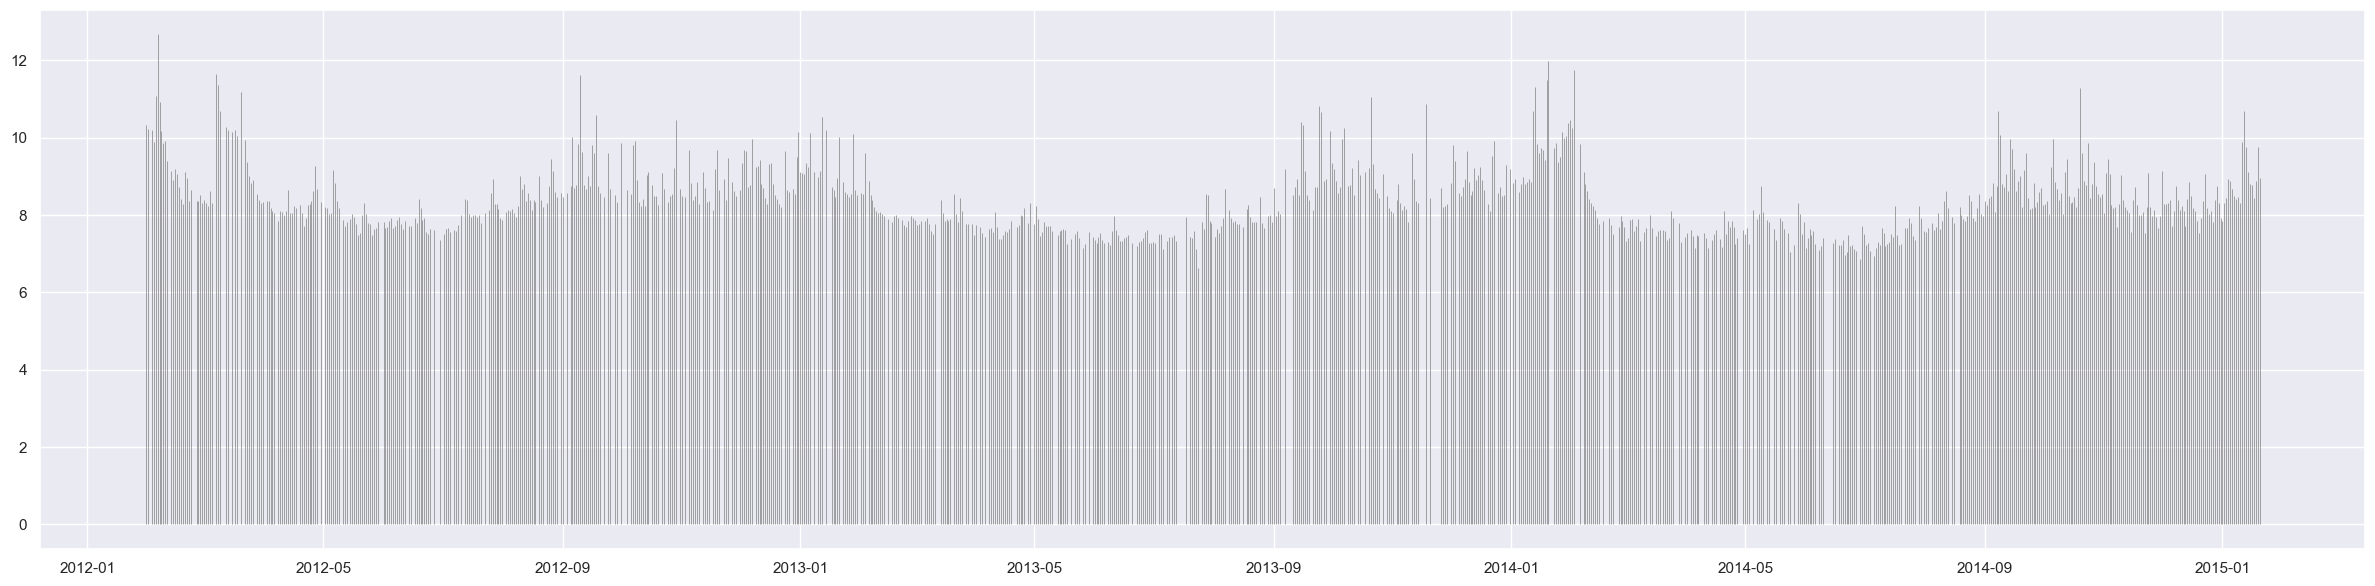

In [9]:
sns.set_theme()

fig, ax = plt.subplots(figsize=(30, 7))

ax.vlines(
    x=df_hist.index,
    ymin=0,
    ymax=df_hist,
    linewidth=0.5,
    color='grey')

In [10]:

df_hist = df_hist.asfreq('D').interpolate()
df_hist.isna().sum()

np.int64(0)

<Axes: xlabel='ds', ylabel='y'>

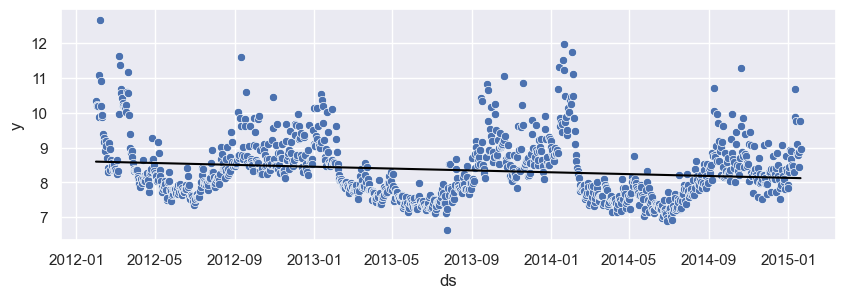

In [11]:

model = LinearRegression().fit(np.arange(len(df_hist)).reshape(-1, 1), df_hist)
trend = model.predict(np.arange(len(df_hist)).reshape(-1, 1))

ax = plt.subplots(figsize=(10, 3))
sns.scatterplot(df_hist)
sns.lineplot(y=trend, x=df_hist.index, c='black')

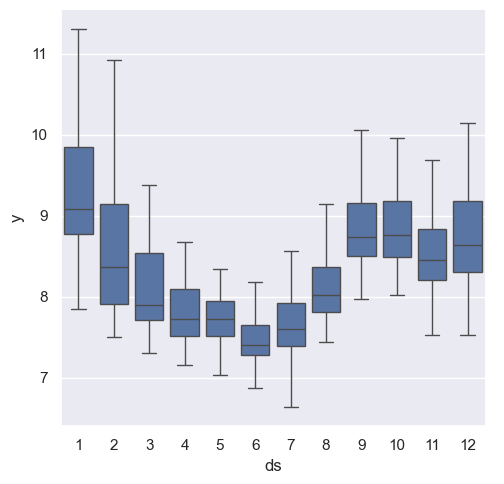

In [12]:
df_mod = df_hist - trend + trend.mean()

sns.catplot(
    y=df_hist,
    x=df_hist.index.month,
    kind='box',
    showfliers=False)

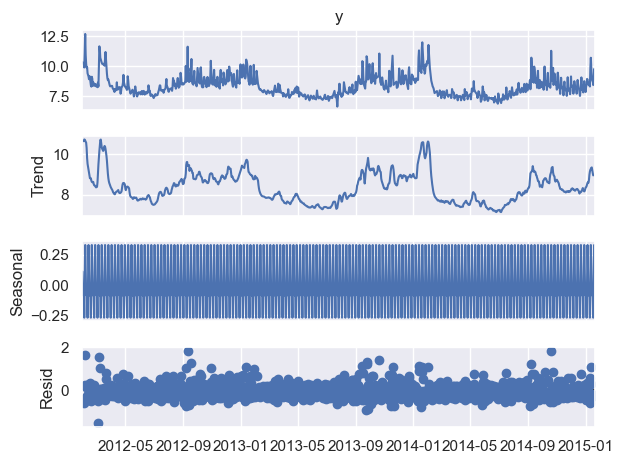

In [13]:
decomp = sm.tsa.seasonal_decompose(df_hist)
decomp_plot = decomp.plot()

In [14]:
df_zscore = zscore(decomp.resid, nan_policy='omit')

In [15]:

def zscore_adv(x, window):
    r = x.rolling(window=window)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z


df_zscore_adv = zscore_adv(decomp.resid, window=7)

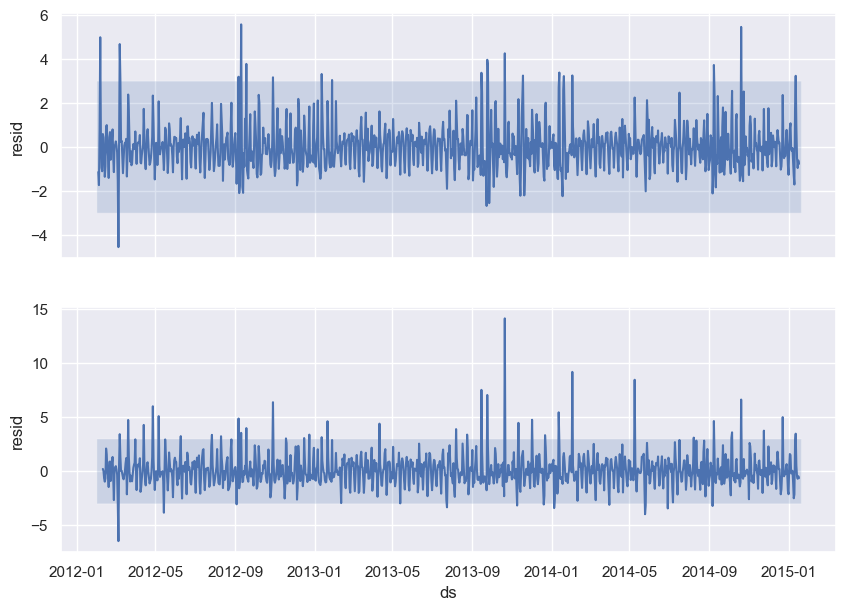

In [16]:

fig, axes = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=True,
    figsize=(10, 7))

for i, d in enumerate([df_zscore, df_zscore_adv]):
    ax = axes[i]
    sns.lineplot(d, ax=ax)
    ax.fill_between(d.index.values, -3, 3, alpha=0.2)

In [17]:
playoffs = pd.DataFrame({
    'holiday': 'playoff',
    'ds': pd.to_datetime(['2013-01-12',
                        '2014-01-12',
                          '2014-01-19',
                          '2014-02-02',
                          '2015-01-11',
                          '2016-01-17']),
    'lower_window': 0,
    'upper_window': 1})

superbowls = pd.DataFrame({
    'holiday': 'superbowl',
    'ds': pd.to_datetime(['2014-02-02']),
    'lower_window': 0,
    'upper_window': 1})

holidays = pd.concat((playoffs, superbowls)).reset_index(drop=True)

holidays

,holiday,ds,lower_window,upper_window
0,playoff,2013-01-12,0,1
1,playoff,2014-01-12,0,1
2,playoff,2014-01-19,0,1
3,playoff,2014-02-02,0,1
4,playoff,2015-01-11,0,1
5,playoff,2016-01-17,0,1
6,superbowl,2014-02-02,0,1


<Axes: xlabel='ds', ylabel='y'>

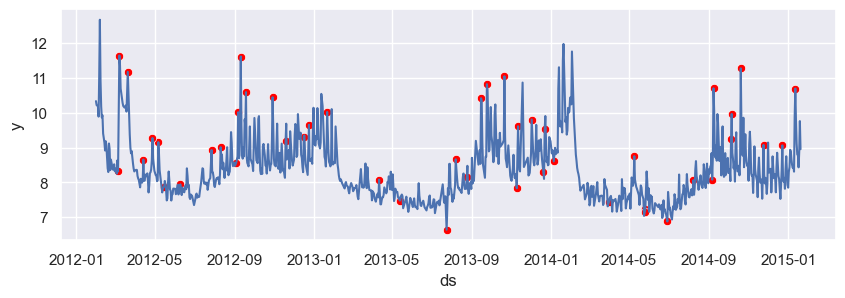

In [18]:
outliers = np.where(~df_zscore_adv.between(-3, 3) * df_zscore_adv.notna())[0]

outliers = list(set(df_hist.index[outliers]).difference(holidays['ds']))

fig, ax = plt.subplots(figsize=(10, 3))
sns.lineplot(df_hist, ax=ax)
sns.scatterplot(
    x=outliers,
    y=df_hist[outliers],
    color='red',
    ax=ax)

In [19]:

df_hist.loc[outliers] = np.nan
df_hist = df_hist.interpolate()

In [21]:

df_hist = df_hist.reset_index()

In [22]:

mp = Prophet(holidays=holidays)
mp.add_seasonality(name='yearly', period=365, fourier_order=2)
mp.fit(df_hist)

18:41:52 - cmdstanpy - INFO - Chain [1] start processing
18:41:52 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
future = mp.make_future_dataframe(freq='D', periods=365)
forecast = mp.predict(future)

forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1446,2016-01-16,7.323987,6.602491,8.026760
1447,2016-01-17,9.585486,8.908188,10.306985
1448,2016-01-18,9.785189,9.107651,10.500497
1449,2016-01-19,7.662020,6.889456,8.373318
1450,2016-01-20,7.479904,6.809929,8.175346


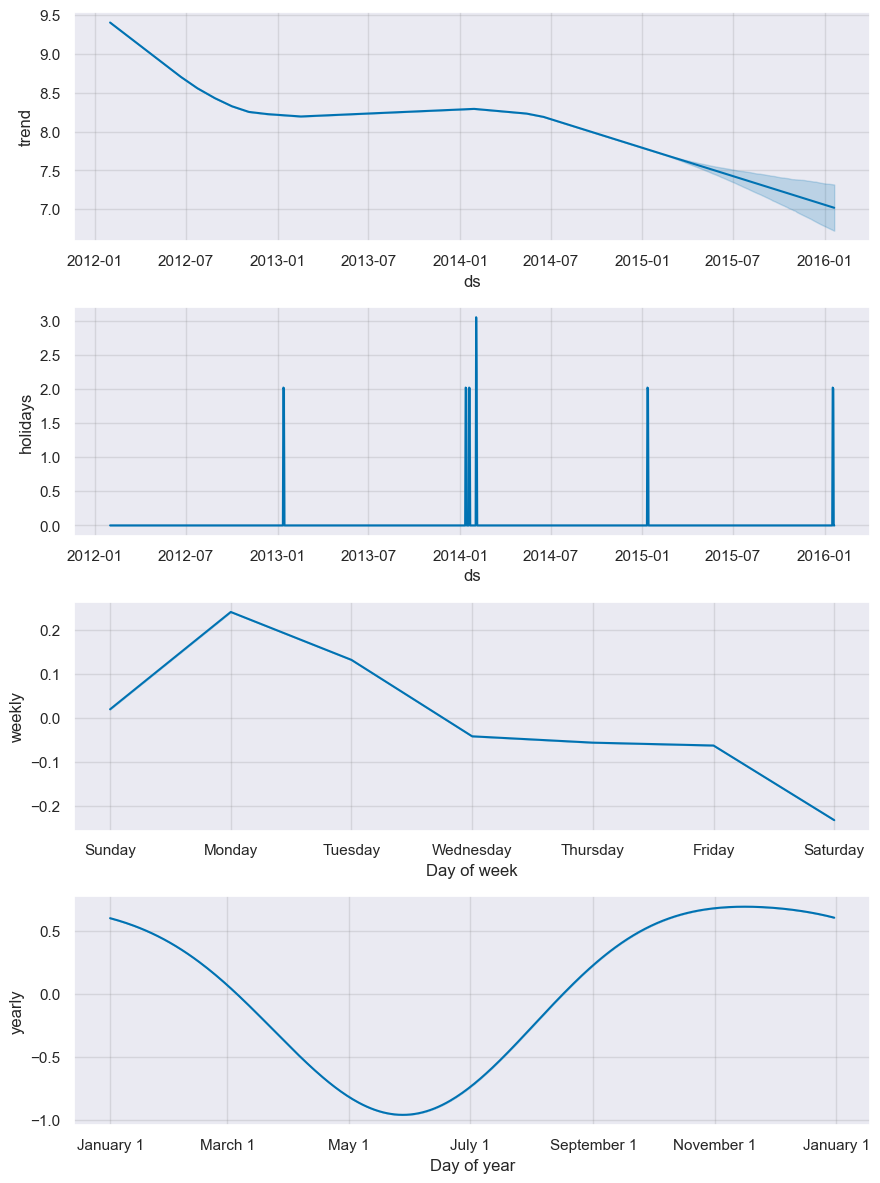

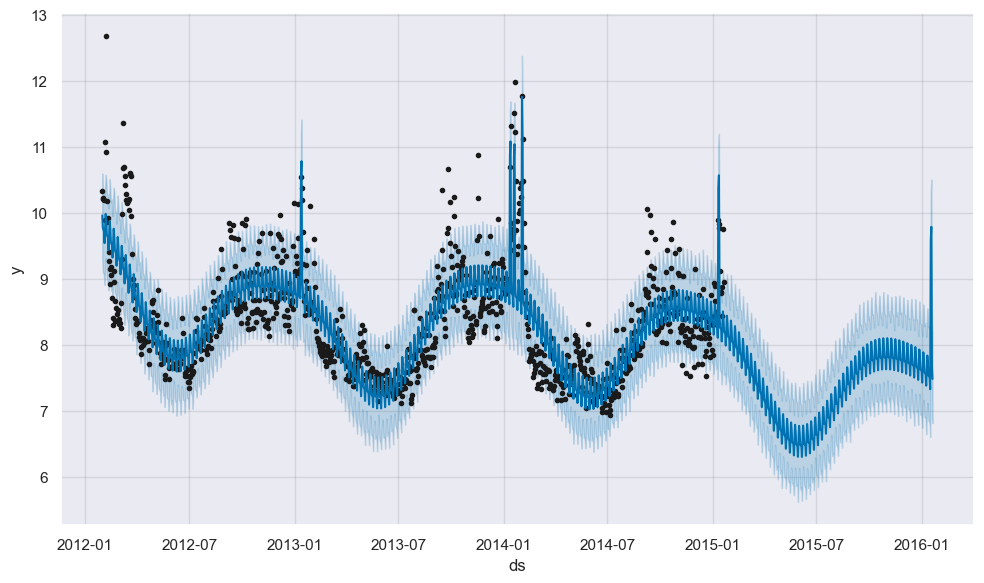

In [24]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

    mp.plot_components(forecast)
    mp.plot(forecast)

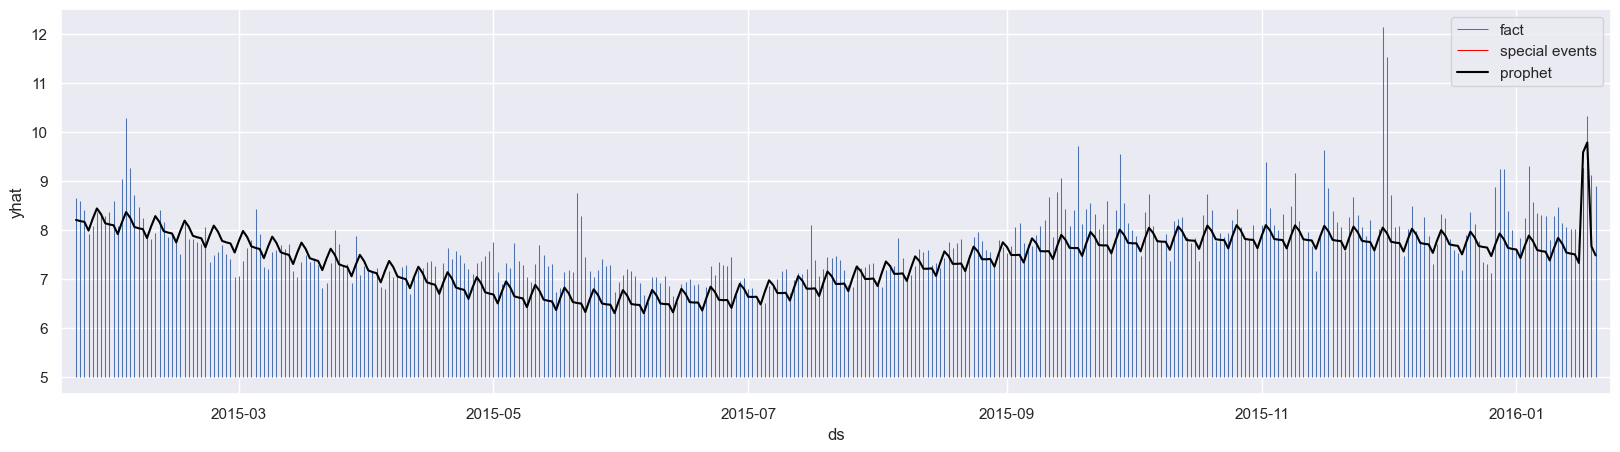

In [25]:
pred = forecast.iloc[-365:][['ds', 'yhat']]

fig, ax = plt.subplots(figsize=(20, 5))

ax.vlines(
    x=df_test.index,
    ymin=5,
    ymax=df_test,
    linewidth=0.75,
    label='fact',
    zorder=1)

ax.vlines(
    x=df_test[df_test.index.isin(holidays['ds'])].index,
    ymin=5,
    ymax=df_test[df_test.index.isin(holidays['ds'])],
    linewidth=0.75,
    color='red',
    label='special events',
    zorder=2)

sns.lineplot(data=pred, y='yhat', x='ds', c='black', label='prophet', ax=ax)

ax.margins(x=0.01)

In [28]:
approx_mape = median_absolute_error(df_test, pred['yhat'])
print(f'Accuracy: {1 - approx_mape:.1%}')

Accuracy: 67.7%
